In [1]:
! pip install statsmodels

In [2]:
! pip freeze > requirements.txt

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind, shapiro, mannwhitneyu

pd.set_option("display.max_colwidth", 100)

# Lectura y transformación de datos


In [4]:
datos = pd.read_excel("datos/EXPORT.xlsx", skiprows=7)
datos.head(3)

,Num,Country,Company,Total operating revenue,Operational Status,City,Business Description/Products,Industry (NAICS),Main Activities (NAICS),Secondary Activities (NAICS),...,% Change from 3 Year Low,% Change from 5 Year Low,Fiscal Year,Audited,Consolidated,Source,EMIS ID,CO-NIT,ISIN,Ticker Symbol
0,1,Colombia,Ecopetrol S.A.,1.427485e+08,Operational,Bogota D.C.,Ecopetrol S.A. was founded in 1948 and is the largest and the principal petroleum company in Col...,Natural Gas Extraction(21113); Crude Petroleum Extraction(21112),Natural Gas Extraction(21113); Crude Petroleum Extraction(21112),NaN,...,-0.4,-0.42,2023.0,Audited,Consolidated,Superfinanciera – IFRS,1192567.0,899999068,"COC04PA00016, US2791581091",ECOPETROL
1,2,Colombia,Organizacion Terpel S.A.,3.625272e+07,Operational,Bogota D.C.,"Organizacion Terpel S.A. distributes and sells fuel products for automobiles, aircraft, and moto...",Petroleum and Petroleum Products Merchant Wholesalers (except Bulk Stations and Terminals)(42472...,Petroleum and Petroleum Products Merchant Wholesalers (except Bulk Stations and Terminals)(42472...,NaN,...,NaN,NaN,2023.0,Audited,Consolidated,Superfinanciera – IFRS,1208163.0,830095213,COG20PA00021,TERPEL
2,3,Colombia,D1 S A S,1.742413e+07,Operational,Bogota D.C.,"D1 S.A.S, with its brand of Tiendas D1, was created in 2009 in Medellín, becoming the first disc...",Grocery Stores(4451),Grocery Stores(4451),NaN,...,NaN,NaN,2023.0,Audited,Individual,Superintendencia de Sociedades - IFRS Financial Statements: Real Sector,3524378.0,900276962,,


In [5]:
datos = datos[0:10000]
datos = datos.loc[
    :,
    (
        "Main Activities (NAICS)",
        "Free cash flow",
        "Long term Debt",
        "Short Term Debt",
        "Quick Ratio (x)",
        "Number of Employees",
        "Total operating revenue",
        "Return on Assets (ROA) (%)",
        "Return on Equity (ROE) (%)"
    )
]

In [6]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Main Activities (NAICS)     10000 non-null  object 
 1   Free cash flow              12 non-null     float64
 2   Long term Debt              9887 non-null   float64
 3   Short Term Debt             9887 non-null   float64
 4   Quick Ratio (x)             9770 non-null   float64
 5   Number of Employees         9673 non-null   object 
 6   Total operating revenue     10000 non-null  float64
 7   Return on Assets (ROA) (%)  10000 non-null  float64
 8   Return on Equity (ROE) (%)  9964 non-null   float64
dtypes: float64(7), object(2)
memory usage: 703.2+ KB


In [7]:
datos.columns

Index(['Main Activities (NAICS)', 'Free cash flow', 'Long term Debt',
       'Short Term Debt', 'Quick Ratio (x)', 'Number of Employees',
       'Total operating revenue', 'Return on Assets (ROA) (%)',
       'Return on Equity (ROE) (%)'],
      dtype='object')

In [8]:
datos.shape

(10000, 9)

In [9]:
datos.head(3)

,Main Activities (NAICS),Free cash flow,Long term Debt,Short Term Debt,Quick Ratio (x),Number of Employees,Total operating revenue,Return on Assets (ROA) (%),Return on Equity (ROE) (%)
0,Natural Gas Extraction(21113); Crude Petroleum Extraction(21112),NaN,90265519.23,15550007.72,1.34,"19,601 (2024)",1.427485e+08,8.26,22.60
1,Petroleum and Petroleum Products Merchant Wholesalers (except Bulk Stations and Terminals)(42472...,NaN,3171446.29,1088524.14,0.89,"1,582 (2024)",3.625272e+07,3.06,10.37
2,Grocery Stores(4451),NaN,0.00,9555.73,0.33,"19,780 (2023)",1.742413e+07,5.19,167.99


In [10]:
datos.to_csv("datos/Pruebas2.csv")

In [11]:
# Expandir la columna NAICS, conservando solo el indice 0, si tiene más de un valor por regist
datos['NAICS'] = datos['Main Activities (NAICS)'].str.split(';')
datos['NAICS'] = datos['NAICS'].apply(lambda x: x[0] if isinstance(x, list) else x)
# Expandir la columna Numero de empleados en el numero y el año del dato:
datos[['Employees', 'Year_Employees']] = datos['Number of Employees'].str.extract(r'([\d,]+)\s\((\d{4})\)')
datos['Employees'] = datos['Employees'].str.replace(',', '').replace('', np.nan).astype(float)
# datos['Year_Employees'] = datos['Year_Employees'].replace('', np.nan).astype(float)
# Eliminar columnas
datos.drop(columns=["Main Activities (NAICS)", "Free cash flow", "Number of Employees", "Year_Employees"], inplace=True)
datos.sample(3)

,Long term Debt,Short Term Debt,Quick Ratio (x),Total operating revenue,Return on Assets (ROA) (%),Return on Equity (ROE) (%),NAICS,Employees
8024,0.0,0.00,3.85,10748.88,23.98,54.94,Gasoline Stations(4471),7.0
8642,1514.3,48.39,0.62,9764.33,-5.00,-980.64,Rental and Leasing Services(532),23.0
3977,0.0,0.00,2.26,26403.58,12.31,21.66,Advertising Agencies(54181),58.0


In [12]:
datos.head()

,Long term Debt,Short Term Debt,Quick Ratio (x),Total operating revenue,Return on Assets (ROA) (%),Return on Equity (ROE) (%),NAICS,Employees
0,90265519.23,15550007.72,1.34,1.427485e+08,8.26,22.60,Natural Gas Extraction(21113),19601.0
1,3171446.29,1088524.14,0.89,3.625272e+07,3.06,10.37,Petroleum and Petroleum Products Merchant Wholesalers (except Bulk Stations and Terminals)(42472),1582.0
2,0.00,9555.73,0.33,1.742413e+07,5.19,167.99,Grocery Stores(4451),19780.0
3,7253638.57,2180692.21,0.74,1.672487e+07,6.60,13.98,Electric Power Generation(22111),2601.0
4,150353.59,106914.23,1.80,1.542435e+07,27.61,40.46,Support Activities for Oil and Gas Operations(213112),5340.0


In [13]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Long term Debt              9887 non-null   float64
 1   Short Term Debt             9887 non-null   float64
 2   Quick Ratio (x)             9770 non-null   float64
 3   Total operating revenue     10000 non-null  float64
 4   Return on Assets (ROA) (%)  10000 non-null  float64
 5   Return on Equity (ROE) (%)  9964 non-null   float64
 6   NAICS                       10000 non-null  object 
 7   Employees                   9673 non-null   float64
dtypes: float64(7), object(1)
memory usage: 625.1+ KB


# Análisis de las columnas de interes


## NAICS


In [14]:
datos["NAICS"].describe(include="object")

count                                                   10000
unique                                                    415
top       Computer Systems Design and Related Services(54151)
freq                                                      334
Name: NAICS, dtype: object

- Hay un total de 10,000 entradas en la columna, lo que indica que no hay nulos para esta variable
- Existen 415 categorías distintas (valores únicos) de actividades representadas
- La categoría más común es "Computer Systems Design and Related Services (54151)", que aparece 334 veces


In [15]:
frecuencia_naics = pd.DataFrame(datos['NAICS'].value_counts(normalize=True).head(10)).reset_index(drop=False)
frecuencia_naics['proportion'] = frecuencia_naics['proportion'] * 100
display(frecuencia_naics)

,NAICS,proportion
0,Computer Systems Design and Related Services(54151),3.34
1,"Machinery, Equipment, and Supplies Merchant Wholesalers(4238)",2.98
2,Other Heavy and Civil Engineering Construction(2379),2.70
3,Drugs and Druggists' Sundries Merchant Wholesalers(4242),2.51
4,Engineering Services(54133),2.37
5,Lumber and Other Construction Materials Merchant Wholesalers(4233),2.29
6,Grocery and Related Product Merchant Wholesalers(4244),2.20
7,Residential Building Construction(23611),1.86
8,Investigation and Security Services(5616),1.84
9,Management of Companies and Enterprises(55111),1.84


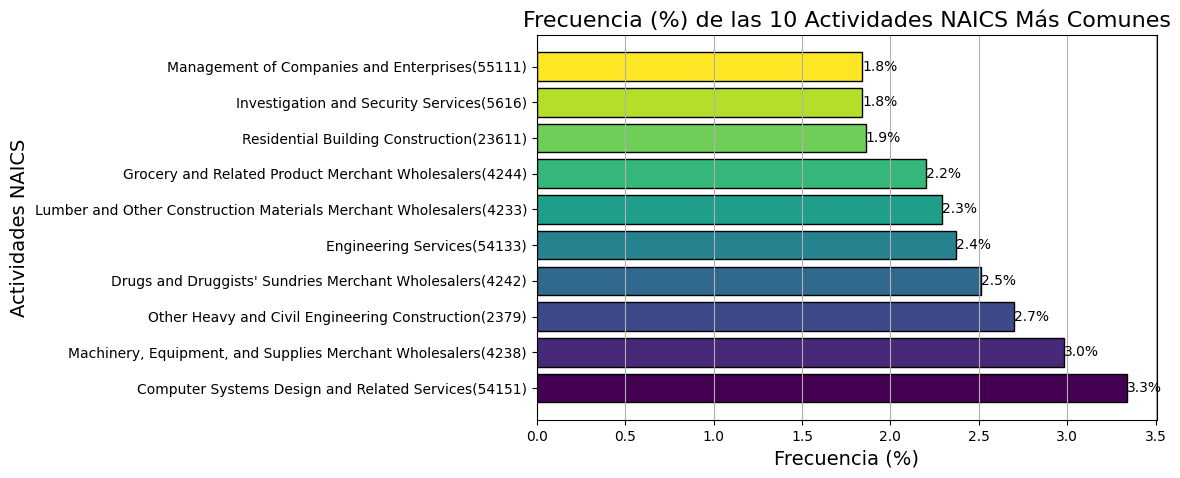

In [16]:
naics_labels = frecuencia_naics['NAICS']
frequencies = frecuencia_naics['proportion']

plt.figure(figsize=(8, 5))
bars = plt.barh(
    naics_labels,
    frequencies,
    edgecolor='black',
    color=plt.get_cmap('viridis')(np.linspace(0, 1, len(frequencies)))
)

plt.title('Frecuencia (%) de las 10 Actividades NAICS Más Comunes', fontsize=16)
plt.xlabel('Frecuencia (%)', fontsize=14)
plt.ylabel('Actividades NAICS', fontsize=14)
plt.grid(axis='x')

# Etiquetas
for index, value in enumerate(frequencies):
    plt.text(value, index, f'{value:.1f}%', va='center')

plt.show()

## Long term Debt


In [17]:
datos["Long term Debt"].describe()

count    9.887000e+03
mean     2.869239e+04
std      1.157930e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.026552e+07
Name: Long term Debt, dtype: float64

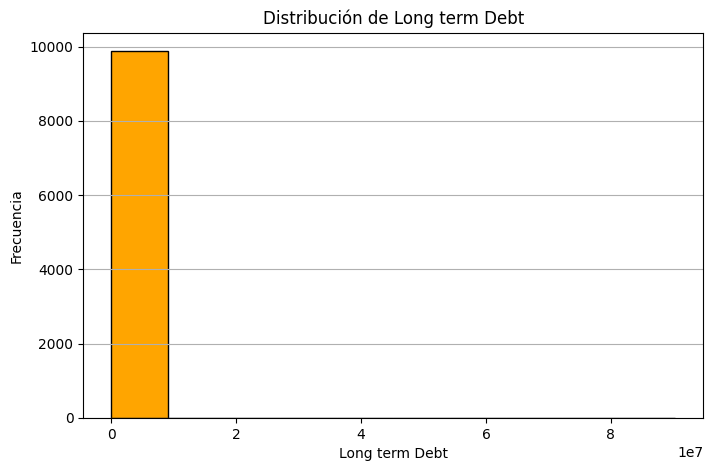

In [18]:
plt.figure(figsize=(8, 5))
plt.hist(datos['Long term Debt'].dropna(), color='orange', edgecolor='black')
plt.title('Distribución de Long term Debt')
plt.xlabel('Long term Debt')
plt.ylabel('Frecuencia')
plt.grid(axis='y')
plt.show()

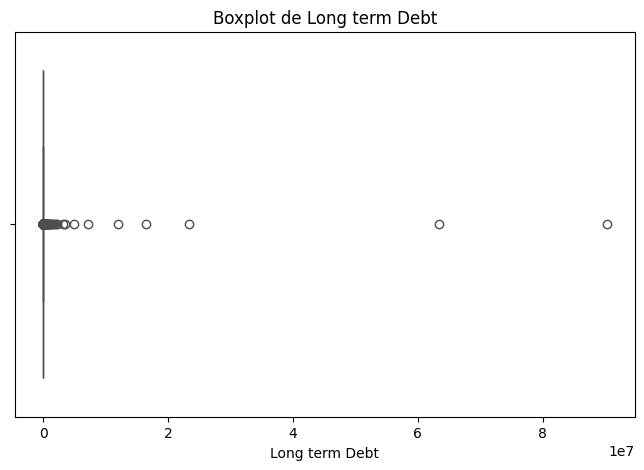

In [19]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos['Long term Debt'], color='orange')
plt.title('Boxplot de Long term Debt')
plt.show()

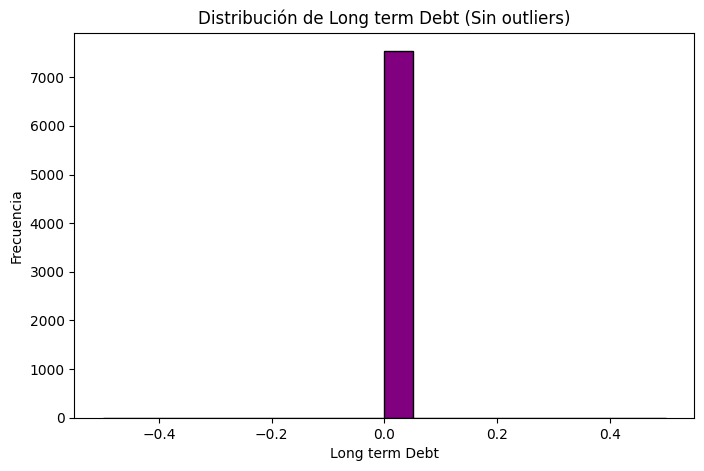

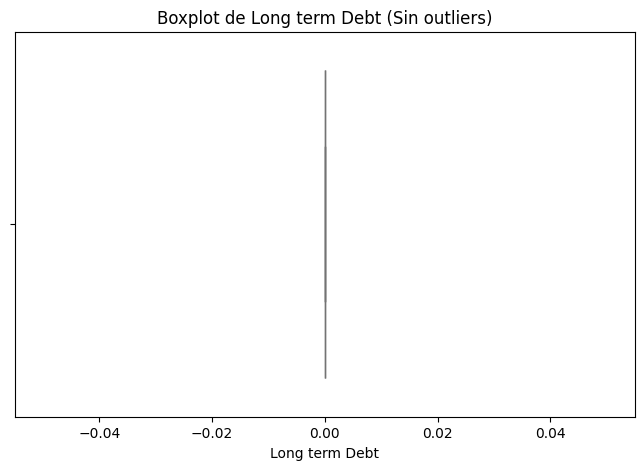

Kurtosis: nan
Asimetría: nan


In [20]:
# Eliminar outliers de la columna 'Long term Debt' utilizando el IQR
Q1 = datos['Long term Debt'].quantile(0.25)
Q3 = datos['Long term Debt'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para eliminar los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 3 * IQR

# Filtrar los datos eliminando los outliers
datos_filtrados_long_term_debt = datos[(datos['Long term Debt'] >= lower_bound) & 
                             (datos['Long term Debt'] <= upper_bound)]

# Visualizar el histograma sin outliers
plt.figure(figsize=(8, 5))
plt.hist(datos_filtrados_long_term_debt['Long term Debt'], bins=20, color='purple', edgecolor='black')
plt.title('Distribución de Long term Debt (Sin outliers)')
plt.xlabel('Long term Debt')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot después de eliminar outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos_filtrados_long_term_debt['Long term Debt'], color='lightgreen')
plt.title('Boxplot de Long term Debt (Sin outliers)')
plt.show()

# Cálculo de la kurtosis y la asimetría (skewness)
datos_profit_clean = datos_filtrados_long_term_debt['Long term Debt'].dropna()

# Calcular la kurtosis
kurt = kurtosis(datos_profit_clean, fisher=False)  # Fisher=False para la definición clásica
# Calcular la asimetría (skewness)
skw = skew(datos_profit_clean)

print(f"Kurtosis: {kurt}")
print(f"Asimetría: {skw}")

## Short Term Debt


In [21]:
datos["Short Term Debt"].describe()

count    9.887000e+03
mean     1.886945e+04
std      1.019690e+06
min     -2.208740e+03
25%      0.000000e+00
50%      0.000000e+00
75%      4.393250e+02
max      9.983733e+07
Name: Short Term Debt, dtype: float64

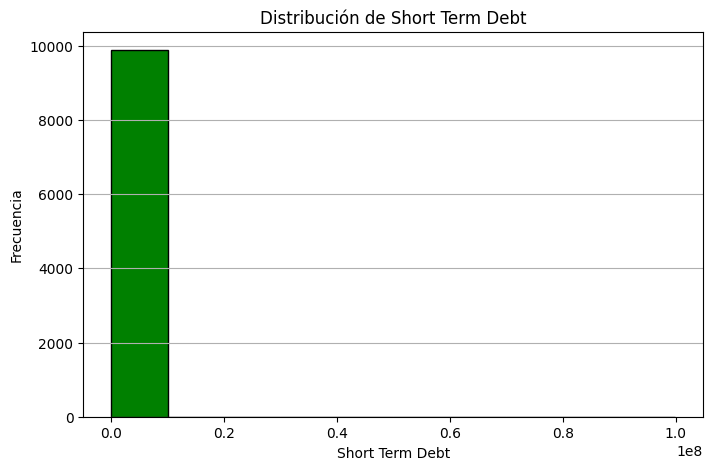

In [22]:
plt.figure(figsize=(8, 5))
plt.hist(datos['Short Term Debt'].dropna(), color='green', edgecolor='black')
plt.title('Distribución de Short Term Debt')
plt.xlabel('Short Term Debt')
plt.ylabel('Frecuencia')
plt.grid(axis='y')
plt.show()

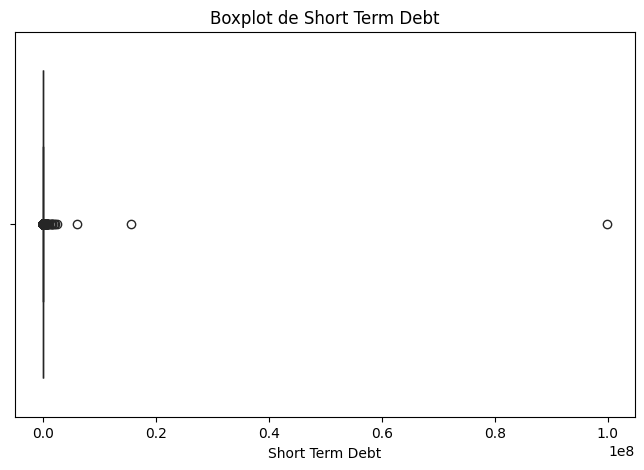

In [23]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos['Short Term Debt'], color='green')
plt.title('Boxplot de Short Term Debt')
plt.show()

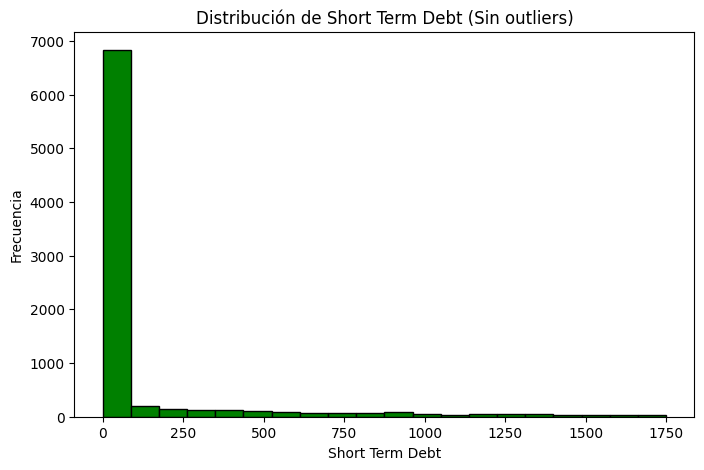

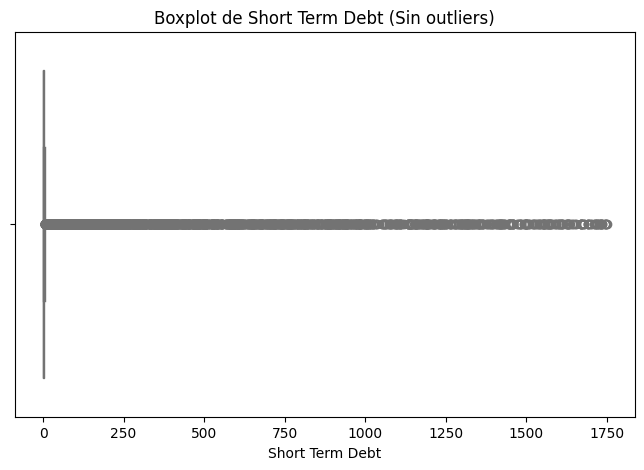

Kurtosis: 11.998450794739794
Asimetría: 3.0638905687578655


In [24]:
# Eliminar outliers de la columna 'Short Term Debt' utilizando el IQR
Q1 = datos['Short Term Debt'].quantile(0.25)
Q3 = datos['Short Term Debt'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para eliminar los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 3 * IQR

# Filtrar los datos eliminando los outliers
datos_filtrados_short_term_debt = datos[(datos['Short Term Debt'] >= lower_bound) & 
                             (datos['Short Term Debt'] <= upper_bound)]

# Visualizar el histograma sin outliers
plt.figure(figsize=(8, 5))
plt.hist(datos_filtrados_short_term_debt['Short Term Debt'], bins=20, color='green', edgecolor='black')
plt.title('Distribución de Short Term Debt (Sin outliers)')
plt.xlabel('Short Term Debt')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot después de eliminar outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos_filtrados_short_term_debt['Short Term Debt'], color='lightgreen')
plt.title('Boxplot de Short Term Debt (Sin outliers)')
plt.show()

# Cálculo de la kurtosis y la asimetría (skewness)
datos_profit_clean = datos_filtrados_short_term_debt['Short Term Debt'].dropna()

# Calcular la kurtosis
kurt = kurtosis(datos_profit_clean, fisher=False)  # Fisher=False para la definición clásica
# Calcular la asimetría (skewness)
skw = skew(datos_profit_clean)

print(f"Kurtosis: {kurt}")
print(f"Asimetría: {skw}")

## Quick Ratio (x)


In [25]:
datos["Quick Ratio (x)"].describe()

count    9770.000000
mean        6.504149
std        72.323400
min         0.000000
25%         1.020000
50%         1.560000
75%         2.660000
max      3364.730000
Name: Quick Ratio (x), dtype: float64

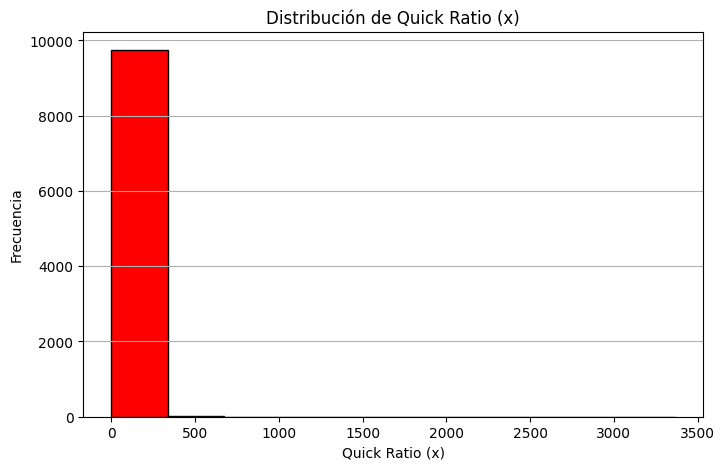

In [26]:
plt.figure(figsize=(8, 5))
plt.hist(datos['Quick Ratio (x)'].dropna(), color='red', edgecolor='black')
plt.title('Distribución de Quick Ratio (x)')
plt.xlabel('Quick Ratio (x)')
plt.ylabel('Frecuencia')
plt.grid(axis='y')
plt.show()

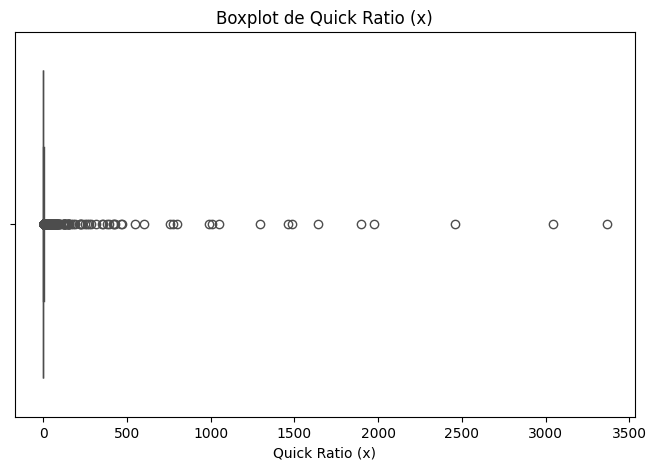

In [27]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos['Quick Ratio (x)'], color='red')
plt.title('Boxplot de Quick Ratio (x)')
plt.show()

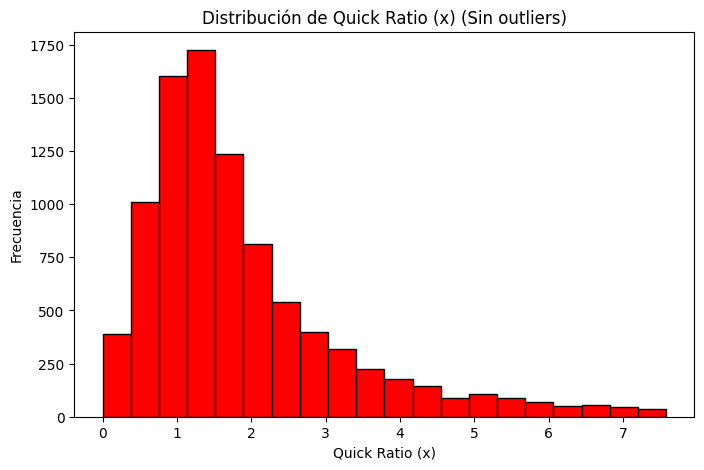

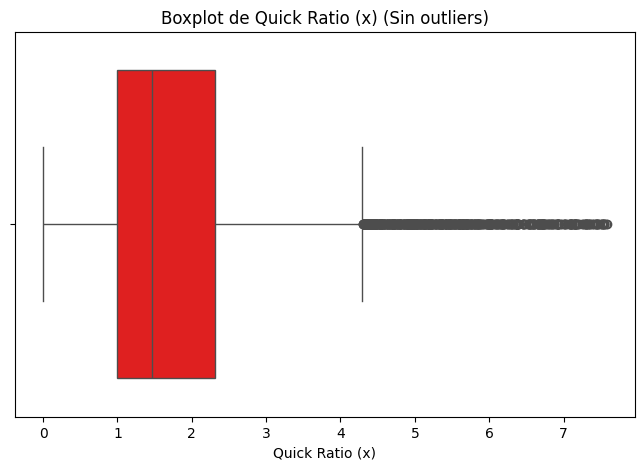

Kurtosis: 5.897954767806844
Asimetría: 1.6526080255563043


In [28]:
# Eliminar outliers de la columna 'Quick Ratio (x)' utilizando el IQR
Q1 = datos['Quick Ratio (x)'].quantile(0.25)
Q3 = datos['Quick Ratio (x)'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para eliminar los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 3 * IQR

# Filtrar los datos eliminando los outliers
datos_filtrados_quick_ratio = datos[(datos['Quick Ratio (x)'] >= lower_bound) & 
                             (datos['Quick Ratio (x)'] <= upper_bound)]

# Visualizar el histograma sin outliers
plt.figure(figsize=(8, 5))
plt.hist(datos_filtrados_quick_ratio['Quick Ratio (x)'], bins=20, color='red', edgecolor='black')
plt.title('Distribución de Quick Ratio (x) (Sin outliers)')
plt.xlabel('Quick Ratio (x)')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot después de eliminar outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos_filtrados_quick_ratio['Quick Ratio (x)'], color='red')
plt.title('Boxplot de Quick Ratio (x) (Sin outliers)')
plt.show()

# Cálculo de la kurtosis y la asimetría (skewness)
datos_profit_clean = datos_filtrados_quick_ratio['Quick Ratio (x)'].dropna()

# Calcular la kurtosis
kurt = kurtosis(datos_profit_clean, fisher=False)  # Fisher=False para la definición clásica
# Calcular la asimetría (skewness)
skw = skew(datos_profit_clean)

print(f"Kurtosis: {kurt}")
print(f"Asimetría: {skw}")

## Total operating revenue


In [29]:
datos["Total operating revenue"].describe()

count    1.000000e+04
mean     1.258037e+05
std      1.576776e+06
min      8.082480e+03
25%      1.177913e+04
50%      1.984062e+04
75%      4.838552e+04
max      1.427485e+08
Name: Total operating revenue, dtype: float64

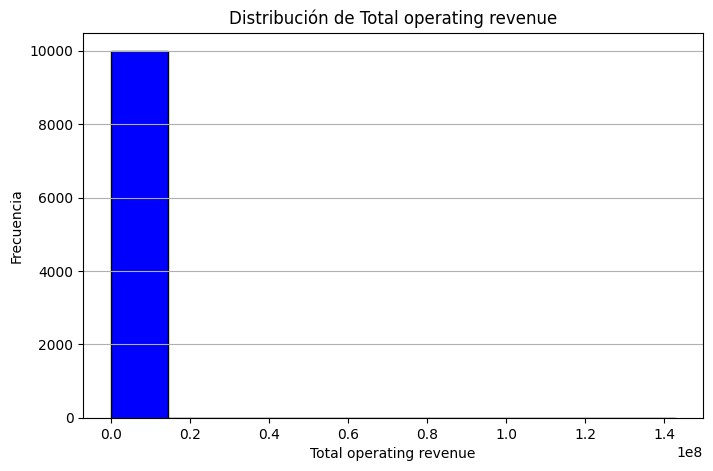

In [30]:
plt.figure(figsize=(8, 5))
plt.hist(datos['Total operating revenue'].dropna(), color='blue', edgecolor='black')
plt.title('Distribución de Total operating revenue')
plt.xlabel('Total operating revenue')
plt.ylabel('Frecuencia')
plt.grid(axis='y')
plt.show()

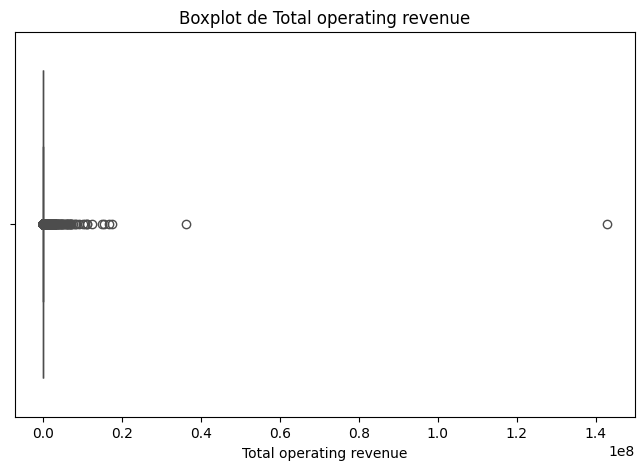

In [31]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos['Total operating revenue'], color='blue')
plt.title('Boxplot de Total operating revenue')
plt.show()

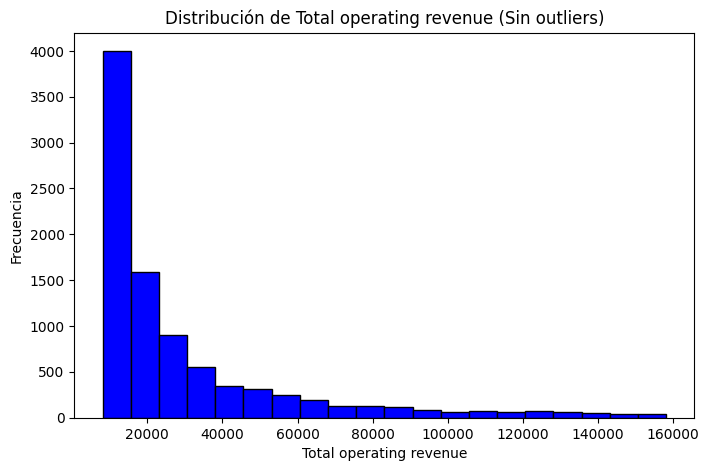

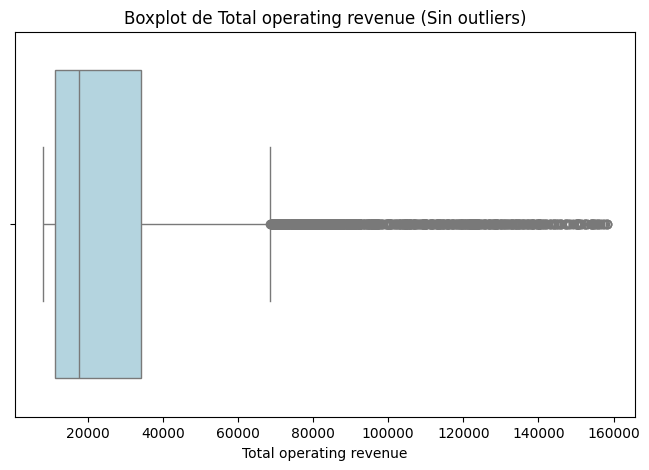

Kurtosis: 7.454829749289521
Asimetría: 2.1558979680092105


In [32]:
# Eliminar outliers de la columna 'Total operating revenue' utilizando el IQR
Q1 = datos['Total operating revenue'].quantile(0.25)
Q3 = datos['Total operating revenue'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para eliminar los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 3 * IQR

# Filtrar los datos eliminando los outliers
datos_filtrados_total_operating_revenue = datos[(datos['Total operating revenue'] >= lower_bound) & 
                             (datos['Total operating revenue'] <= upper_bound)]

# Visualizar el histograma sin outliers
plt.figure(figsize=(8, 5))
plt.hist(datos_filtrados_total_operating_revenue['Total operating revenue'], bins=20, color='blue', edgecolor='black')
plt.title('Distribución de Total operating revenue (Sin outliers)')
plt.xlabel('Total operating revenue')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot después de eliminar outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos_filtrados_total_operating_revenue['Total operating revenue'], color='lightblue')
plt.title('Boxplot de Total operating revenue (Sin outliers)')
plt.show()

# Cálculo de la kurtosis y la asimetría (skewness)
datos_profit_clean = datos_filtrados_total_operating_revenue['Total operating revenue'].dropna()

# Calcular la kurtosis
kurt = kurtosis(datos_profit_clean, fisher=False)  # Fisher=False para la definición clásica
# Calcular la asimetría (skewness)
skw = skew(datos_profit_clean)

print(f"Kurtosis: {kurt}")
print(f"Asimetría: {skw}")

## Return on Assets (ROA) (%)


In [33]:
datos["Return on Assets (ROA) (%)"].describe()

count     10000.000000
mean         94.791161
std        3515.137014
min       -3599.560000
25%           1.417500
50%           5.910000
75%          12.452500
max      276923.080000
Name: Return on Assets (ROA) (%), dtype: float64

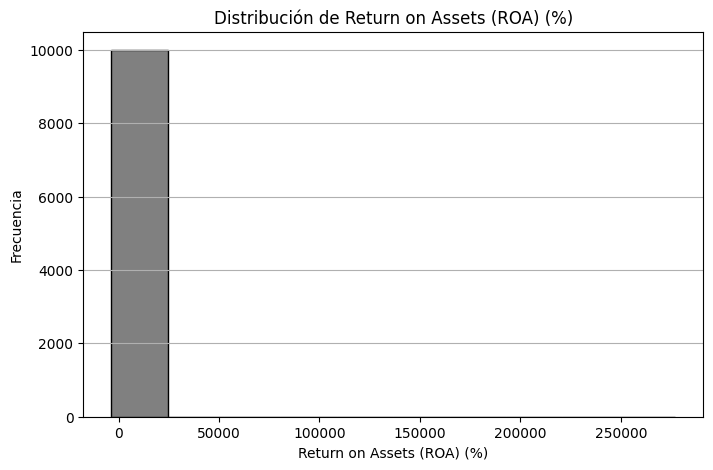

In [34]:
plt.figure(figsize=(8, 5))
plt.hist(datos['Return on Assets (ROA) (%)'].dropna(), color='gray', edgecolor='black')
plt.title('Distribución de Return on Assets (ROA) (%)')
plt.xlabel('Return on Assets (ROA) (%)')
plt.ylabel('Frecuencia')
plt.grid(axis='y')
plt.show()

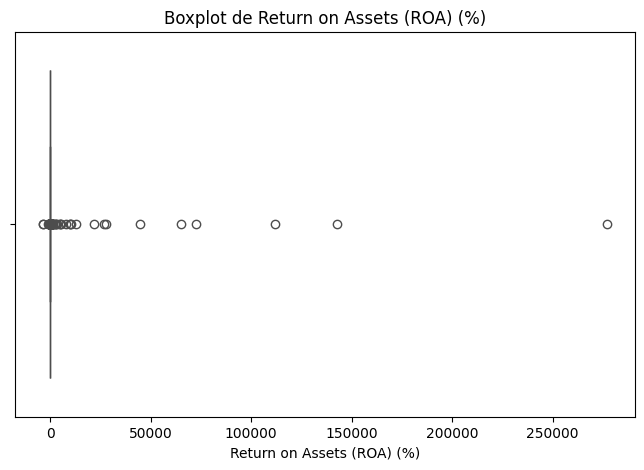

In [35]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos['Return on Assets (ROA) (%)'], color='gray')
plt.title('Boxplot de Return on Assets (ROA) (%)')
plt.show()

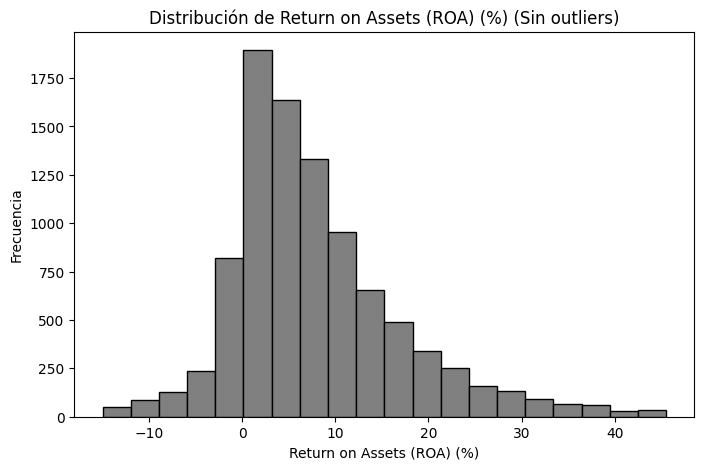

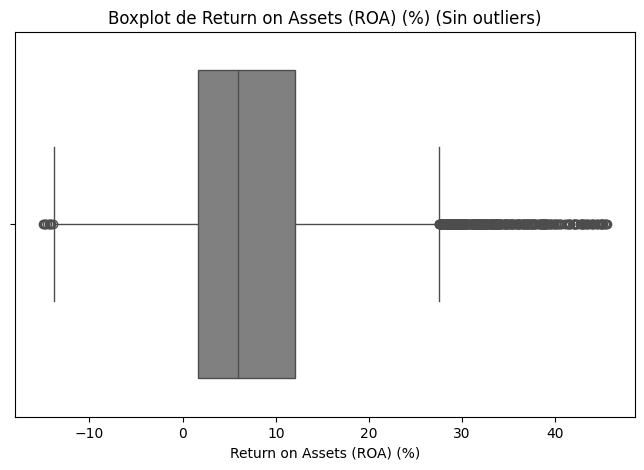

Kurtosis: 4.781607730545578
Asimetría: 1.101120419527189


In [36]:
# Eliminar outliers de la columna 'Return on Assets (ROA) (%)' utilizando el IQR
Q1 = datos['Return on Assets (ROA) (%)'].quantile(0.25)
Q3 = datos['Return on Assets (ROA) (%)'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para eliminar los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 3 * IQR

# Filtrar los datos eliminando los outliers
datos_filtrados_roa = datos[(datos['Return on Assets (ROA) (%)'] >= lower_bound) & 
                             (datos['Return on Assets (ROA) (%)'] <= upper_bound)]

# Visualizar el histograma sin outliers
plt.figure(figsize=(8, 5))
plt.hist(datos_filtrados_roa['Return on Assets (ROA) (%)'], bins=20, color='gray', edgecolor='black')
plt.title('Distribución de Return on Assets (ROA) (%) (Sin outliers)')
plt.xlabel('Return on Assets (ROA) (%)')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot después de eliminar outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos_filtrados_roa['Return on Assets (ROA) (%)'], color='gray')
plt.title('Boxplot de Return on Assets (ROA) (%) (Sin outliers)')
plt.show()

# Cálculo de la kurtosis y la asimetría (skewness)
datos_profit_clean = datos_filtrados_roa['Return on Assets (ROA) (%)'].dropna()

# Calcular la kurtosis
kurt = kurtosis(datos_profit_clean, fisher=False)  # Fisher=False para la definición clásica
# Calcular la asimetría (skewness)
skw = skew(datos_profit_clean)

print(f"Kurtosis: {kurt}")
print(f"Asimetría: {skw}")

## Return on Equity (ROE) (%)


In [37]:
datos["Return on Equity (ROE) (%)"].describe()

count      9964.000000
mean         91.745426
std        8966.995218
min     -735040.220000
25%           4.510000
50%          14.625000
75%          30.335000
max      319889.900000
Name: Return on Equity (ROE) (%), dtype: float64

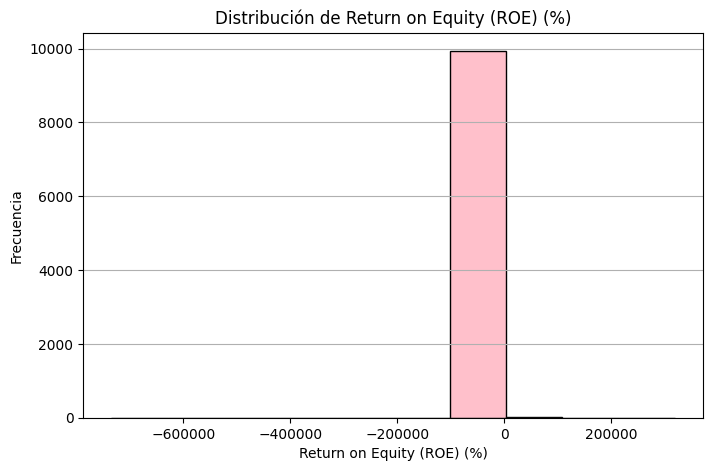

In [38]:
plt.figure(figsize=(8, 5))
plt.hist(datos['Return on Equity (ROE) (%)'].dropna(), color='pink', edgecolor='black')
plt.title('Distribución de Return on Equity (ROE) (%)')
plt.xlabel('Return on Equity (ROE) (%)')
plt.ylabel('Frecuencia')
plt.grid(axis='y')
plt.show()

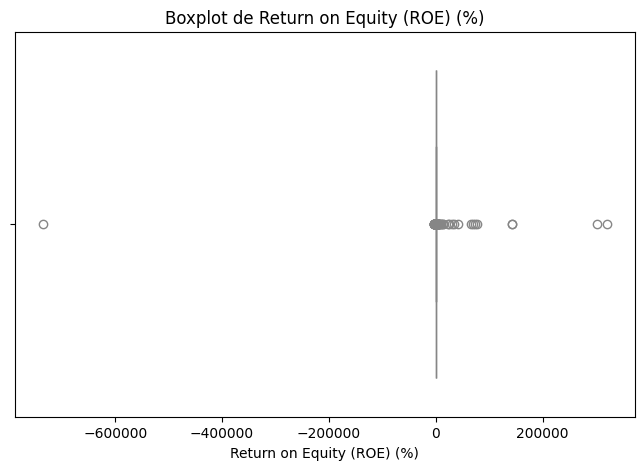

In [39]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos['Return on Equity (ROE) (%)'], color='pink')
plt.title('Boxplot de Return on Equity (ROE) (%)')
plt.show()

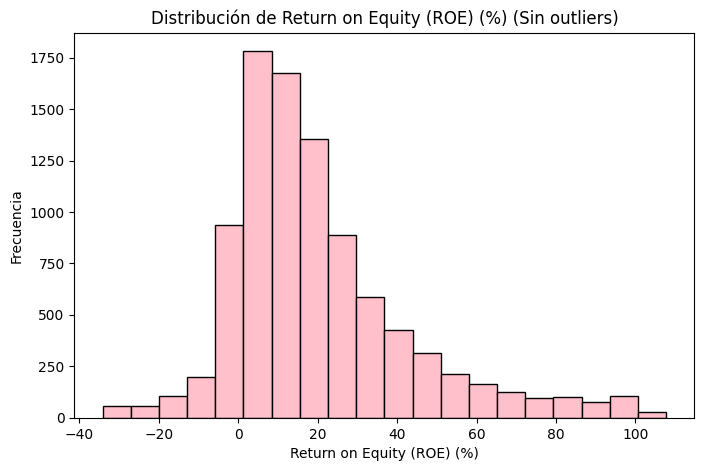

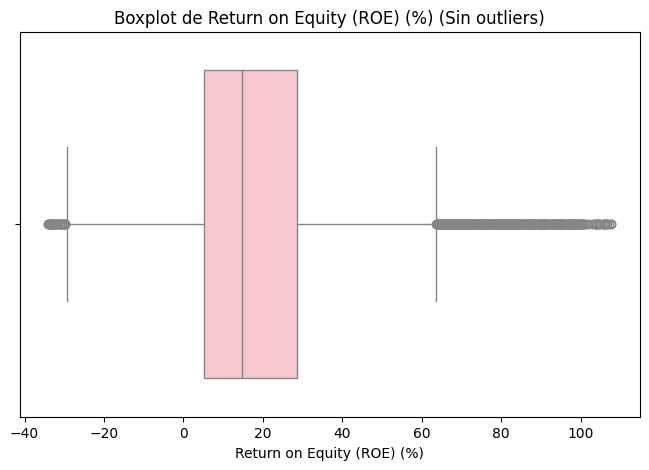

Kurtosis: 5.083171410881358
Asimetría: 1.2929492822298654


In [40]:
# Eliminar outliers de la columna 'Return on Equity (ROE) (%)' utilizando el IQR
Q1 = datos['Return on Equity (ROE) (%)'].quantile(0.25)
Q3 = datos['Return on Equity (ROE) (%)'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para eliminar los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 3 * IQR

# Filtrar los datos eliminando los outliers
datos_filtrados_roe = datos[(datos['Return on Equity (ROE) (%)'] >= lower_bound) & 
                             (datos['Return on Equity (ROE) (%)'] <= upper_bound)]

# Visualizar el histograma sin outliers
plt.figure(figsize=(8, 5))
plt.hist(datos_filtrados_roe['Return on Equity (ROE) (%)'], bins=20, color='pink', edgecolor='black')
plt.title('Distribución de Return on Equity (ROE) (%) (Sin outliers)')
plt.xlabel('Return on Equity (ROE) (%)')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot después de eliminar outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos_filtrados_roe['Return on Equity (ROE) (%)'], color='pink')
plt.title('Boxplot de Return on Equity (ROE) (%) (Sin outliers)')
plt.show()

# Cálculo de la kurtosis y la asimetría (skewness)
datos_profit_clean = datos_filtrados_roe['Return on Equity (ROE) (%)'].dropna()

# Calcular la kurtosis
kurt = kurtosis(datos_profit_clean, fisher=False)  # Fisher=False para la definición clásica
# Calcular la asimetría (skewness)
skw = skew(datos_profit_clean)

print(f"Kurtosis: {kurt}")
print(f"Asimetría: {skw}")

## Employees


In [41]:
datos["Employees"].describe()

count     9673.000000
mean       260.059547
std       1412.108855
min          1.000000
25%         17.000000
50%         50.000000
75%        146.000000
max      73326.000000
Name: Employees, dtype: float64

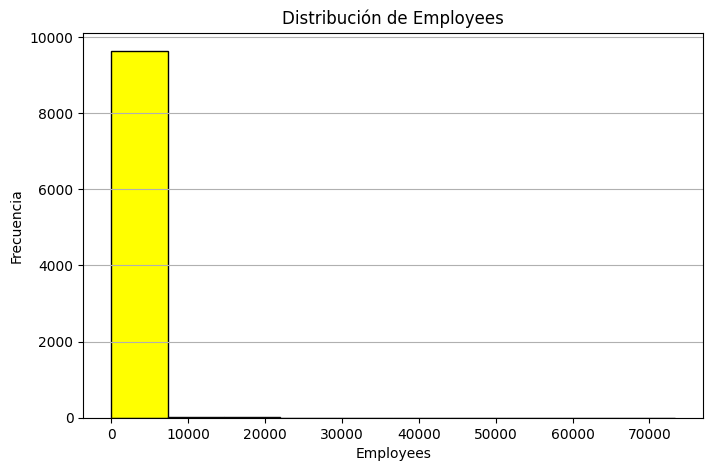

In [42]:
plt.figure(figsize=(8, 5))
plt.hist(datos['Employees'].dropna(), color='yellow', edgecolor='black')
plt.title('Distribución de Employees')
plt.xlabel('Employees')
plt.ylabel('Frecuencia')
plt.grid(axis='y')
plt.show()

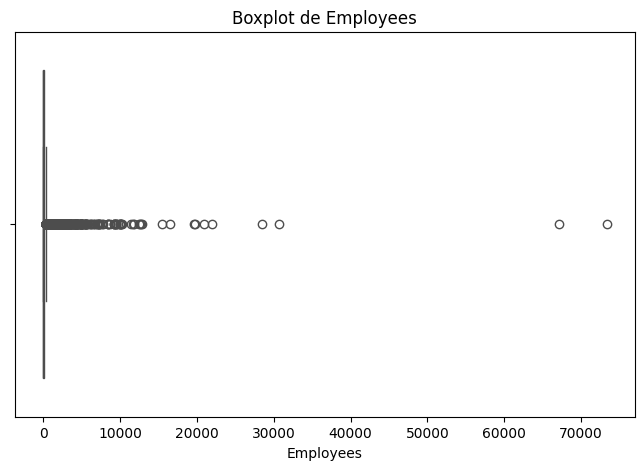

In [43]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos['Employees'], color='blue')
plt.title('Boxplot de Employees')
plt.show()

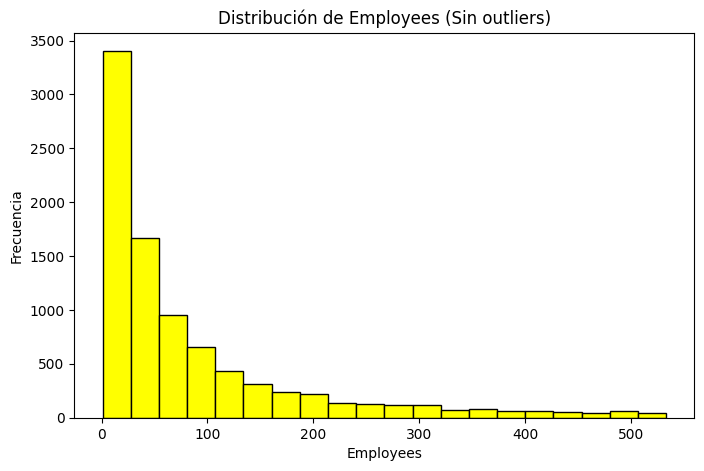

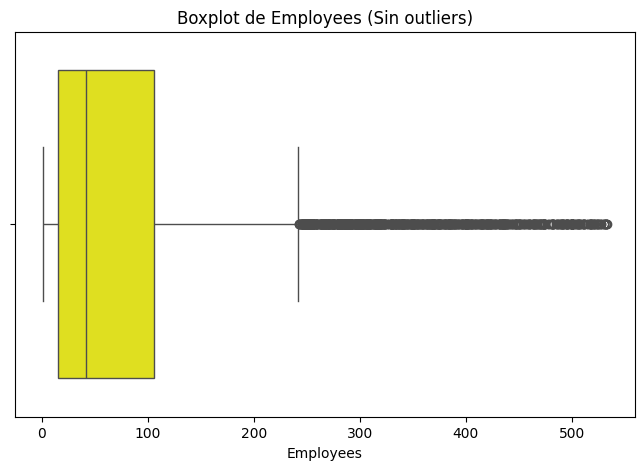

Kurtosis: 6.910836369663698
Asimetría: 2.031127463879265


In [44]:
# Eliminar outliers de la columna 'Employees' utilizando el IQR
Q1 = datos['Employees'].quantile(0.25)
Q3 = datos['Employees'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para eliminar los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 3 * IQR

# Filtrar los datos eliminando los outliers
datos_filtrados_employees = datos[(datos['Employees'] >= lower_bound) & 
                             (datos['Employees'] <= upper_bound)]

# Visualizar el histograma sin outliers
plt.figure(figsize=(8, 5))
plt.hist(datos_filtrados_employees['Employees'], bins=20, color='yellow', edgecolor='black')
plt.title('Distribución de Employees (Sin outliers)')
plt.xlabel('Employees')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot después de eliminar outliers
plt.figure(figsize=(8, 5))
sns.boxplot(x=datos_filtrados_employees['Employees'], color='yellow')
plt.title('Boxplot de Employees (Sin outliers)')
plt.show()

# Cálculo de la kurtosis y la asimetría (skewness)
datos_profit_clean = datos_filtrados_employees['Employees'].dropna()

# Calcular la kurtosis
kurt = kurtosis(datos_profit_clean, fisher=False)  # Fisher=False para la definición clásica
# Calcular la asimetría (skewness)
skw = skew(datos_profit_clean)

print(f"Kurtosis: {kurt}")
print(f"Asimetría: {skw}")

# Multivariado


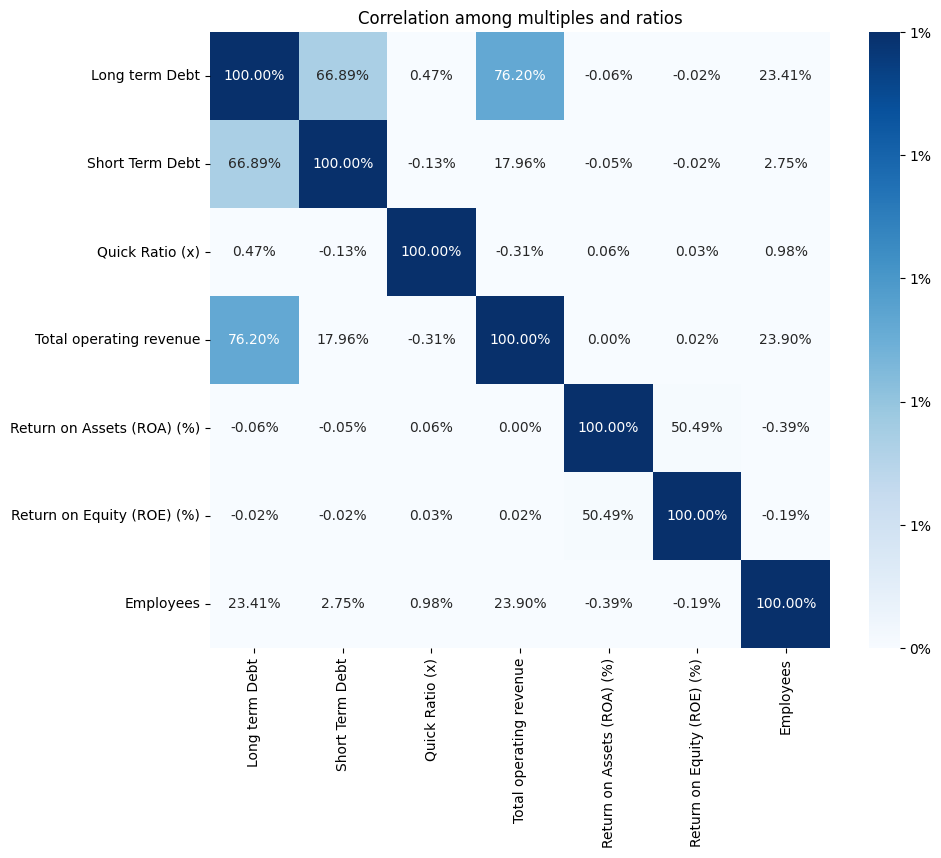

In [45]:
# Plotting correlation heatmap among number variables
plt.figure(figsize=(10, 8))
sns.heatmap(
    datos[["Long term Debt", "Short Term Debt", "Quick Ratio (x)", "Total operating revenue", "Return on Assets (ROA) (%)", "Return on Equity (ROE) (%)", "Employees"]].corr(),
    vmin=0.5, vmax=1,
    cmap="Blues",
    annot=True,
    fmt=".2%",
    cbar_kws={'format': '%.0f%%'}
)
plt.title("Correlation among multiples and ratios")
plt.show()

In [46]:
frequencies = datos["NAICS"].value_counts(normalize=True)

# Agrupar categorías con menos del 1%
frequencies = frequencies.reset_index()
frequencies.columns = ['NAICS', 'frecuencia']
frequencies.loc[frequencies['frecuencia'] < 0.01, 'NAICS'] = 'Otras'

# Frecuencias
grouped_frequencies = frequencies.groupby('NAICS')['frecuencia'].sum().reset_index()

# Calcular la suma acumulativa
grouped_frequencies['cumsum'] = grouped_frequencies['frecuencia'].cumsum()
grouped_frequencies

,NAICS,frecuencia,cumsum
0,Advertising Agencies(54181),0.0157,0.0157
1,Ambulatory Health Care Services(621),0.0118,0.0275
2,"Automotive Parts, Accessories, and Tire Stores(4413)",0.0126,0.0401
3,Chemical and Allied Products Merchant Wholesalers(4246),0.0125,0.0526
4,Computer Systems Design and Related Services(54151),0.0334,0.0860
5,Drugs and Druggists' Sundries Merchant Wholesalers(4242),0.0251,0.1111
6,Employment Placement Agencies(561311),0.0112,0.1223
7,Engineering Services(54133),0.0237,0.1460
8,Farm Product Raw Material Merchant Wholesalers(4245),0.0103,0.1563
9,Gasoline Stations(4471),0.0180,0.1743


In [47]:
most_representative_naics = grouped_frequencies.loc[grouped_frequencies['cumsum'] < 0.80]
most_representative_naics

,NAICS,frecuencia,cumsum
0,Advertising Agencies(54181),0.0157,0.0157
1,Ambulatory Health Care Services(621),0.0118,0.0275
2,"Automotive Parts, Accessories, and Tire Stores(4413)",0.0126,0.0401
3,Chemical and Allied Products Merchant Wholesalers(4246),0.0125,0.0526
4,Computer Systems Design and Related Services(54151),0.0334,0.0860
5,Drugs and Druggists' Sundries Merchant Wholesalers(4242),0.0251,0.1111
6,Employment Placement Agencies(561311),0.0112,0.1223
7,Engineering Services(54133),0.0237,0.1460
8,Farm Product Raw Material Merchant Wholesalers(4245),0.0103,0.1563
9,Gasoline Stations(4471),0.0180,0.1743


In [48]:
# Segmentar y filtrar nulos
datos_seg = datos[datos["NAICS"].isin(most_representative_naics["NAICS"].tolist())]
datos_segmentados = datos_seg.dropna()

In [49]:
datos_segmentados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4138 entries, 2 to 9998
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Long term Debt              4138 non-null   float64
 1   Short Term Debt             4138 non-null   float64
 2   Quick Ratio (x)             4138 non-null   float64
 3   Total operating revenue     4138 non-null   float64
 4   Return on Assets (ROA) (%)  4138 non-null   float64
 5   Return on Equity (ROE) (%)  4138 non-null   float64
 6   NAICS                       4138 non-null   object 
 7   Employees                   4138 non-null   float64
dtypes: float64(7), object(1)
memory usage: 291.0+ KB


In [50]:
datos_segmentados["NAICS"] = datos_segmentados["NAICS"].astype("category")

/tmp/ipykernel_209407/2168502713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_segmentados["NAICS"] = datos_segmentados["NAICS"].astype("category")


In [51]:
formula = (
    'Q("Total operating revenue") ~ Q("Long term Debt") + Q("Short Term Debt") + Q("Quick Ratio (x)") '
    + '+ Q("Return on Assets (ROA) (%)") + Q("Return on Equity (ROE) (%)") + C(NAICS) + Q("Employees") '
    + '+ C(NAICS)*Q("Long term Debt") + Q("Long term Debt")*Q("Short Term Debt")'
)

In [52]:
model = ols(formula, data=datos_segmentados).fit()

In [53]:
anova_results = sm.stats.anova_lm(model, typ=2)  # Type II sum of squares
anova_results

,sum_sq,df,F,PR(>F)
C(NAICS),1.678092e+13,24.0,10.153951,5.275523e-37
"Q(""Long term Debt"")",1.911134e+11,1.0,2.775374,9.580099e-02
"C(NAICS):Q(""Long term Debt"")",5.788976e+12,24.0,3.502846,1.707870e-08
"Q(""Short Term Debt"")",1.433677e+13,1.0,208.200538,4.533576e-46
"Q(""Quick Ratio (x)"")",2.925560e+08,1.0,0.004249,9.480332e-01
"Q(""Return on Assets (ROA) (%)"")",3.767141e+10,1.0,0.547069,4.595601e-01
"Q(""Return on Equity (ROE) (%)"")",3.769486e+10,1.0,0.547410,4.594205e-01
"Q(""Employees"")",8.342298e+13,1.0,1211.479919,1.127701e-232
"Q(""Long term Debt""):Q(""Short Term Debt"")",4.657058e+09,1.0,0.067630,7.948318e-01
Residual,2.810881e+14,4082.0,NaN,NaN


In [54]:
label_encoder = LabelEncoder()
datos_segmentados["NAICS_encoded"] = label_encoder.fit_transform(datos_segmentados["NAICS"])

/tmp/ipykernel_209407/3398745552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_segmentados["NAICS_encoded"] = label_encoder.fit_transform(datos_segmentados["NAICS"])


In [55]:
datos_segmentados.sample(3)

,Long term Debt,Short Term Debt,Quick Ratio (x),Total operating revenue,Return on Assets (ROA) (%),Return on Equity (ROE) (%),NAICS,Employees,NAICS_encoded
1406,0.0,400.0,2.12,99759.53,10.85,19.11,Other Business Support Services(56149),2151.0,21
5954,0.0,0.0,1.08,15737.70,15.68,35.58,Grocery and Related Product Merchant Wholesalers(4244),65.0,12
3994,0.0,0.0,1.45,26194.80,6.37,17.65,Chemical and Allied Products Merchant Wholesalers(4246),25.0,3


In [56]:
datos_segmentados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4138 entries, 2 to 9998
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Long term Debt              4138 non-null   float64 
 1   Short Term Debt             4138 non-null   float64 
 2   Quick Ratio (x)             4138 non-null   float64 
 3   Total operating revenue     4138 non-null   float64 
 4   Return on Assets (ROA) (%)  4138 non-null   float64 
 5   Return on Equity (ROE) (%)  4138 non-null   float64 
 6   NAICS                       4138 non-null   category
 7   Employees                   4138 non-null   float64 
 8   NAICS_encoded               4138 non-null   int64   
dtypes: category(1), float64(7), int64(1)
memory usage: 295.7 KB


In [57]:
selected_naics = [
    "Computer Systems Design and Related Services(54151)",
    "Machinery, Equipment, and Supplies Merchant Wholesalers(4238)"
]

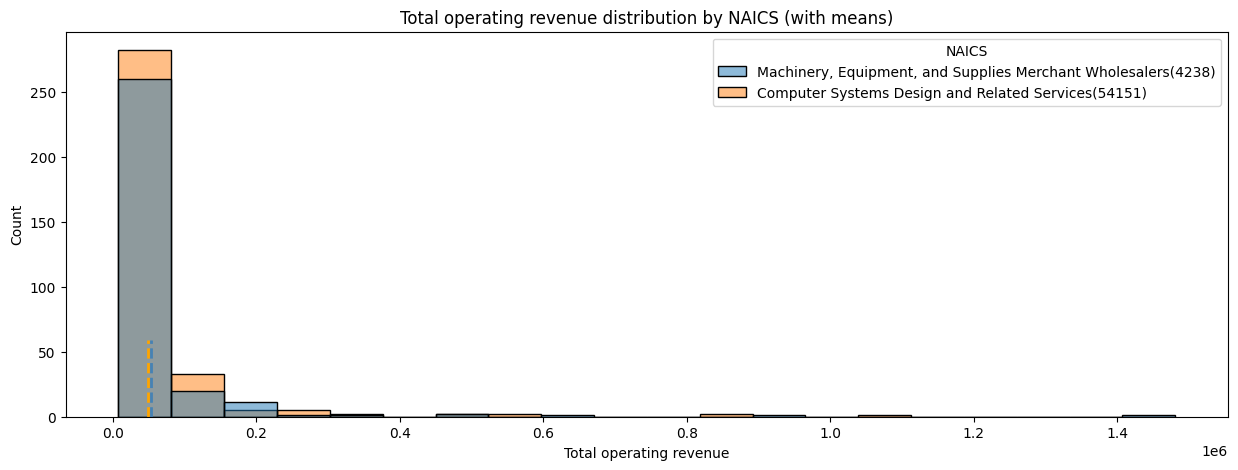

In [58]:
# Plotting total operating revenue distribution by 2 segmented NAICS
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(
    data=datos.loc[datos["NAICS"].isin(selected_naics)],
    x="Total operating revenue",
    hue="NAICS",
    bins=20,
    ax=ax
)
for (naic_code, color) in zip(selected_naics, ["steelblue", "orange"]):
    ax.axvline(datos.loc[datos["NAICS"] == naic_code, "Total operating revenue"].mean(), color=color, linestyle="dashed", linewidth=2, ymax=0.2)
plt.title("Total operating revenue distribution by NAICS (with means)")
plt.show()

In [59]:
alpha = 0.01

In [60]:
# Assuming normality
t_stat, p_value = ttest_ind(
    datos.loc[datos["NAICS"] == selected_naics[0], "Total operating revenue"],
    datos.loc[datos["NAICS"] == selected_naics[1], "Total operating revenue"],
    equal_var=False
)

In [61]:
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 0.37568775405590915
P-value: 0.7072790726930798


In [62]:
# Testing normality for each group
print(f"{selected_naics[0]}:", shapiro(datos.loc[datos["NAICS"] == selected_naics[0], "Total operating revenue"])[1])
print(f"{selected_naics[1]}:", shapiro(datos.loc[datos["NAICS"] == selected_naics[1], "Total operating revenue"])[1])

# Applying a non-parametric test
t_stat, p_value = mannwhitneyu(
    datos.loc[datos["NAICS"] == selected_naics[0], "Total operating revenue"],
    datos.loc[datos["NAICS"] == selected_naics[1], "Total operating revenue"]
)

print("T-statistic:", t_stat)
print("P-value:", p_value)

Computer Systems Design and Related Services(54151): 5.029767241451946e-32
Machinery, Equipment, and Supplies Merchant Wholesalers(4238): 6.680178946102276e-32
T-statistic: 49759.0
P-value: 0.9977366055938028
